# Notebook to test modules and establish a workflow

In [1]:
# Regular imports
import sys
import os

import numpy as np
import scipy.special as sps
import scipy.constants as spc
import scipy.interpolate as spinter
import scipy.optimize as spopt
import scipy.fft as ft
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
# from matplotlib import rc, rcParams
import time
from datetime import datetime
from PIL import Image

plt.style.use('./xri_plot.mplstyle')
plt.close('all')
%matplotlib widget

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

In [2]:
# import custom modules -> re-run if changed

import images
import instrument
import process
import analysis

In [3]:
# parameters

energy = 6.4 # 3.0
counts = int(1e6)
time_step = 1

img_path = './Models/hmxb_corr.jpg'
img_scale = 550e-6 # width of image in arcsec

baselines = np.linspace(0.05, 1.0, 20)

double_size = False

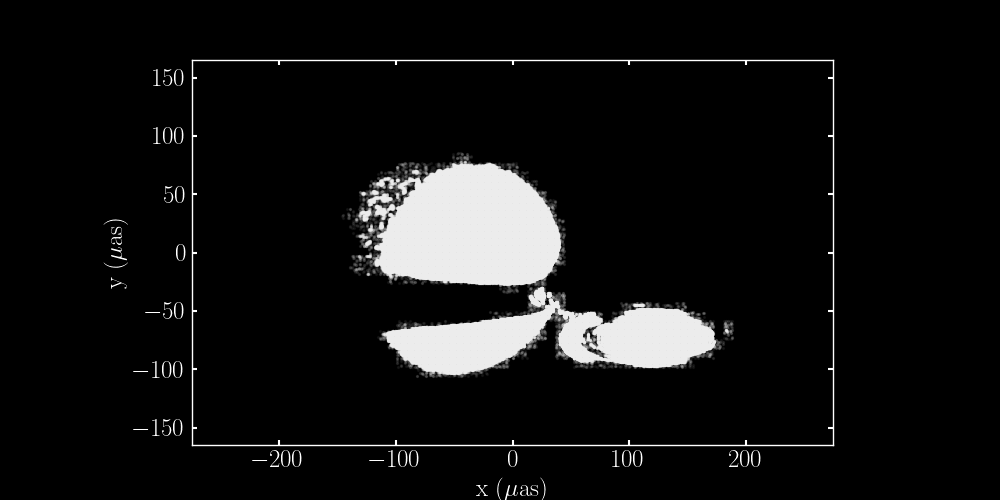

In [4]:
img, pix_scale = images.generate_from_image(img_path, counts, img_scale, energy)

if double_size:
    img_scale *= 2
    pix_scale *= 2

scale = np.array([img_scale, pix_scale[0]/pix_scale[1] * img_scale]) * 1e6 # convert arcsec to microarcsec
extent=(-scale[0]/2, scale[0]/2, -scale[1]/2, scale[1]/2)

corr_factor = 1 / (1e-6 * (2 * np.pi / (3600 * 360)))
# plot image to check
plt.close('all')
# plt.figure(figsize=(10, 5))
# # Create a 2D histogram (density plot) instead of scatter
x = img.loc[:,0] * corr_factor
y = img.loc[:,1] * corr_factor
# hist = plt.hist2d(y, -x, bins=pix_scale[::-1], cmap='inferno', density=True)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar(label='counts')
# # plt.xlim(-300, 300)
# # plt.ylim(-1000, 1000)
date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
# plt.show()
# plt.savefig(f'Figures/original_image_{date_str}.png', dpi=400, bbox_inches='tight', pad_inches=0)
# Replace 2D histogram with scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(y, -x, s=2, c='white', alpha=0.05)
plt.gca().set_aspect('equal')
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.xlim(-scale[0]/2, scale[0]/2)
plt.ylim(-scale[1]/2, scale[1]/2)
# plt.savefig(f'Figures/original_image_{date_str}_scatter.png', dpi=400, bbox_inches='tight')
plt.show()

inst = instrument.interferometer(time_step, roller = instrument.interferometer.smooth_roller, roll_init = 0, roll_speed = np.pi / (np.max(img.toa)* time_step))

for i in baselines:
    inst.add_willingale_baseline(i)



In [5]:
# generate PSF of initialised setup
def generate_psf(energy, counts, img_scale, inst, samples = pix_scale):
    
    point_source = images.point_source(counts, alpha = 0, beta = 0, energy = energy)
    psf_data = process.interferometer_data(inst, point_source)
    psf, uv, obj = analysis.image_recon_smooth(psf_data, inst, img_scale, samples = samples)
    return psf, uv

simulated_psf, uv = generate_psf(energy, counts, img_scale, inst, samples = pix_scale)

# save PSF to file using numpy
np.save('simulated_psf.npy', simulated_psf[0])

simulated_psf = np.load('simulated_psf.npy')
# # plot the PSF
# psf = simulated_psf / np.sum(simulated_psf)
# im_ratio = psf.shape[0] / psf.shape[1]
# plt.figure(figsize = (6, 6))
# plt.imshow(psf*1e3, cmap = 'inferno', extent=extent, aspect='equal')
# plt.colorbar(fraction=0.0475*im_ratio, pad=0.02, label='PSF (arbitrary units)')
# plt.title('PSF of Interferometer')
# plt.xlabel('x ($\\mu$as)')
# plt.ylabel('y ($\\mu$as)')
# plt.show()
# plt.tight_layout()


In [6]:
# process 

data = process.interferometer_data(inst, img)

In [7]:
# reconstruct the image

recon, uv, obj = analysis.image_recon_smooth(data, inst, img_scale, samples = pix_scale, progress=1, error=0.03, recon_type = 'IFFT')



<>:59: SyntaxWarning: invalid escape sequence '\D'
<>:60: SyntaxWarning: invalid escape sequence '\D'
<>:59: SyntaxWarning: invalid escape sequence '\D'
<>:60: SyntaxWarning: invalid escape sequence '\D'
/var/folders/fn/72t1j4cn2b7gn_2dhs83dn_c0000gn/T/ipykernel_10216/537059734.py:59: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$u/\Delta f$')
/var/folders/fn/72t1j4cn2b7gn_2dhs83dn_c0000gn/T/ipykernel_10216/537059734.py:60: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$v/\Delta f$')


(13320, 13320)
[        0.          15485345.81434657  30970691.62869314 ...
 -46456037.44303972 -30970691.62869314 -15485345.81434657]
[ 0.  1.  2. ... -3. -2. -1.]


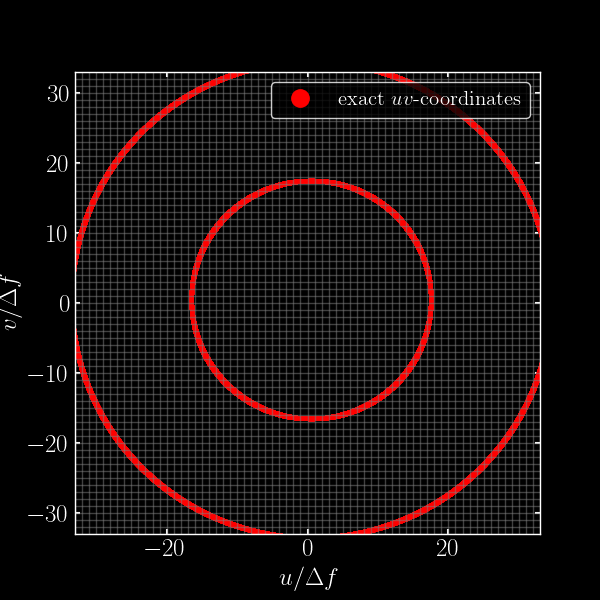

In [8]:
from scipy.stats import binned_statistic_2d

%matplotlib widget
plt.close('all')
# print keys of obj
# plot obj.ft_image in the same style as below
ft_img = np.fft.fftshift(np.abs(obj.ft_image))
# ft_img = np.abs(obj.ft_image)
print(np.shape(ft_img))
n = np.shape(ft_img)[0]
print(obj.fft_freqs)
d = 1 / (np.abs(obj.fft_freqs[1] - obj.fft_freqs[0]) * n)
freqs = obj.fft_freqs * n * d
print(freqs)


# fig = plt.figure(figsize = (6, 6))
# plt.imshow(np.abs(ft_img), cmap = 'inferno', aspect='equal', norm=LogNorm(), extent=(np.min(freqs), np.max(freqs), np.min(freqs), np.max(freqs)))
# plt.gca().invert_yaxis()
# plt.colorbar(fraction=0.047, pad=0.02, label='Sum of photons per uv-cell')
# plt.xlim(-120, 120)
# plt.ylim(-120, 120)
# plt.title('')
# plt.xlabel('u')
# plt.ylabel('v')
# plt.show()

# # plot uv-coordinates
# fig = plt.figure(figsize=(6,6))
# plt.plot(obj.uv_conv[:, 0], obj.uv_conv[:, 1], 'bs', markersize=10, alpha=0.1)
# plt.plot(obj.uv[:,0]*n*d, obj.uv[:,1]*n*d, 'g.', markersize=5, alpha=0.1)
# plt.xlim(0,25.5)
# plt.ylim(0,25.5)
# plt.title("uv-plane sampling")
# plt.xlabel('u')
# plt.ylabel('v')



# plot uv-coordinates as a density plot on the grid spanned by freqs

# bin uv_conv coordinates onto the freqs grid
freqs_sorted = np.sort(freqs)
H, xedges, yedges, binnumber = binned_statistic_2d(
    obj.uv_conv[:, 0], obj.uv_conv[:, 1], None,
    statistic='count', bins=[freqs_sorted, freqs_sorted]
)

fig = plt.figure(figsize=(6, 6))
# plt.imshow(
#     H, origin='lower', cmap='viridis',
#     extent=(np.min(freqs), np.max(freqs), np.min(freqs), np.max(freqs)),
#     aspect='equal', norm=LogNorm()
# )
mul = 1.02
add = 0.5
# plt.colorbar(fraction=0.047, pad=0.02, label='Photons per $uv$-bin')
plt.plot(obj.uv[:,0]*n*d * mul + add, obj.uv[:,1]*n*d * mul + add, '.', color='red', markersize=5, alpha=1.0, label='exact $uv$-coordinates')
plt.xlabel('$u/\Delta f$')
plt.ylabel('$v/\Delta f$')
plt.xlim(-33, 33)
plt.ylim(-33, 33)
for f in freqs:
    plt.axhline(f, color='gray', linewidth=1, alpha=0.5)
    plt.axvline(f, color='gray', linewidth=1, alpha=0.5)
plt.legend(loc='upper right', fontsize='small', markerscale=5)
plt.show()

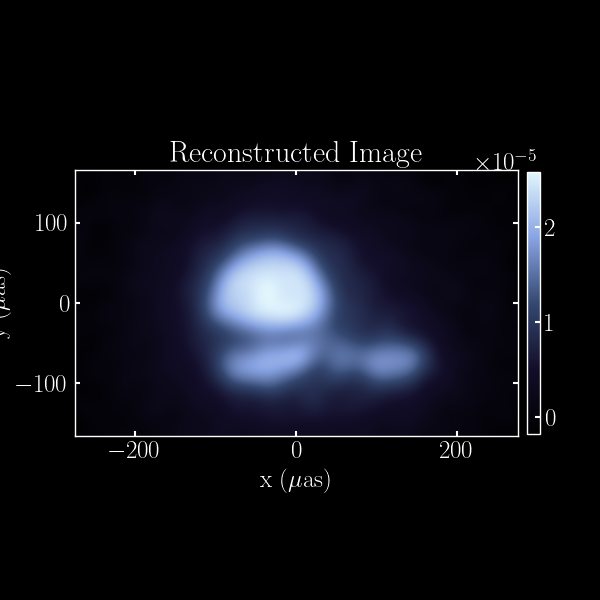

In [9]:
from skimage.transform import resize
plt.close('all')

# normalise reconstructed image
reconstructed = recon[0]
# reconstructed = reconstructed + np.abs(np.min(reconstructed))
# reconstructed = (reconstructed - np.min(reconstructed)) / (np.max(reconstructed) - np.min(reconstructed))

colors = ['#000000', "#5C83D8D0", "#FFFFFF"]
colors_chandra = [
    "#000000",  # very dark (near black)
    "#130E29",  # deep navy
    "#344871",  # dark blue
    "#89A4E3",  # mid-to-light blue
    "#E2F6FE"   # bright white-blue
]

cmap = LinearSegmentedColormap.from_list('black_to_blue', colors_chandra, N=1e4)




im_ratio = reconstructed.shape[0] / reconstructed.shape[1]
# plot the reconstructed image
# plot the reconstructed image
reconst = reconstructed  / np.sum(reconstructed)

# Increase resolution by a factor of 4 in each dimension
new_shape = (reconst.shape[0]*4, reconst.shape[1]*4)
reconst_highres = resize(reconst, new_shape, mode='wrap', anti_aliasing=True)

# Update extent for new resolution
extent_highres = (extent[0], extent[1], extent[2], extent[3])

# Use reconst_highres for plotting below if desired

plt.figure(figsize = (6, 6))
plt.imshow(reconst_highres, cmap=cmap, extent=extent_highres)
plt.colorbar(fraction=0.047*im_ratio, pad=0.02)
plt.title('Reconstructed Image')
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.show()



# plot the same image, but only the image part and save it as a png with date in filename
plt.figure(figsize = (8, 6))
plt.imshow(reconst_highres, cmap=cmap, extent=extent_highres)
plt.axis('off')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'Figures/reconstructed_image_{date_str}.png', format='png', dpi=1000, bbox_inches='tight', pad_inches=0)
plt.close()

In [10]:
import images
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d

img_path = './Models/hmxb_corr.jpg'
original = Image.open(img_path).convert('L')
original_array = np.array(original)
if double_size:
    pad = (np.array((pix_scale[0]/3, pix_scale[0]/3)).astype(int), np.array((pix_scale[1]/3, pix_scale[1]/3)).astype(int))
    # expand the original image to match the reconstructed image size
    original_array = np.pad(original_array, pad, mode='constant', constant_values=0)

# plot the same image, but only the image part and save it as a png with date in filename
# plt.figure(figsize = (6, 6))
# plt.imshow(original_array / np.sum(original_array), cmap='inferno', vmin=1e-7)
# plt.axis('off')
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
# plt.savefig(f'Figures/original_image_{date_str}.png', dpi=400, bbox_inches='tight', pad_inches=0)
# plt.close()



In [11]:
convolved_test = convolve2d(original_array, simulated_psf, mode='same', boundary='wrap')

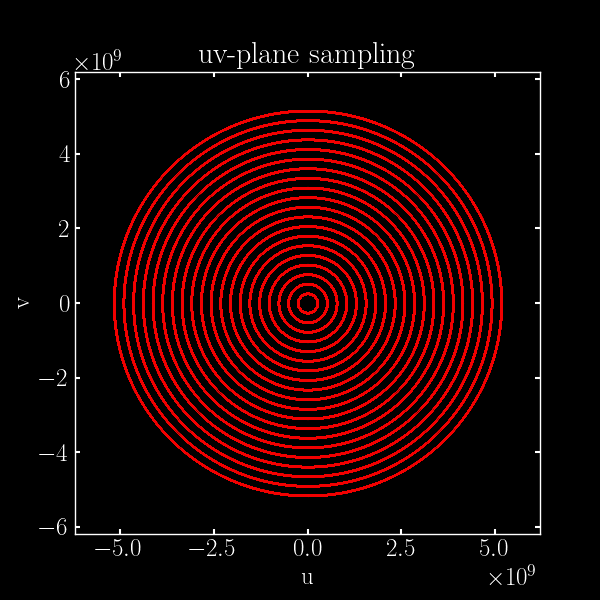

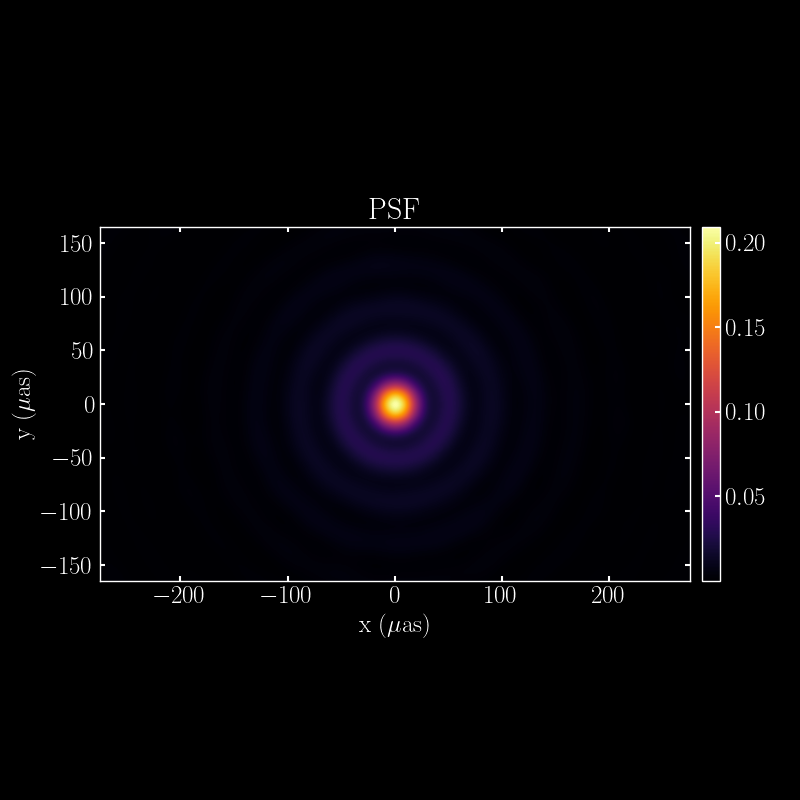

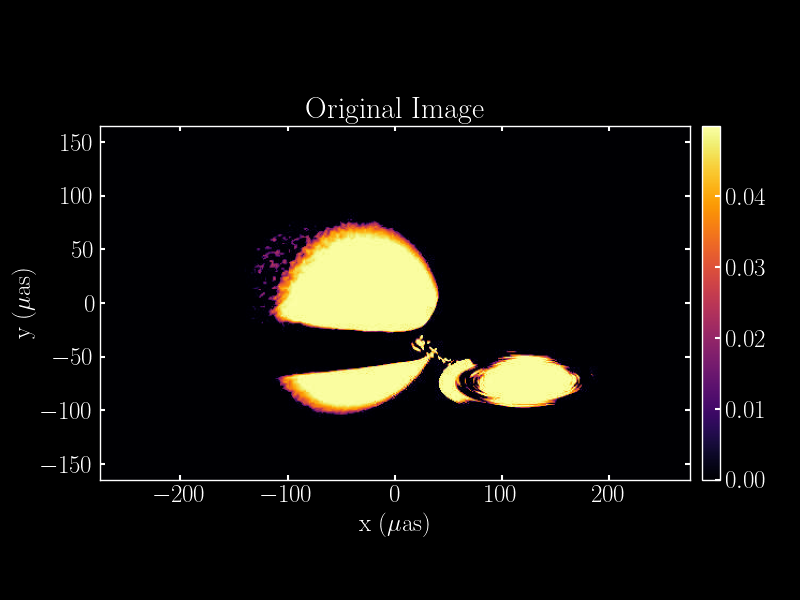

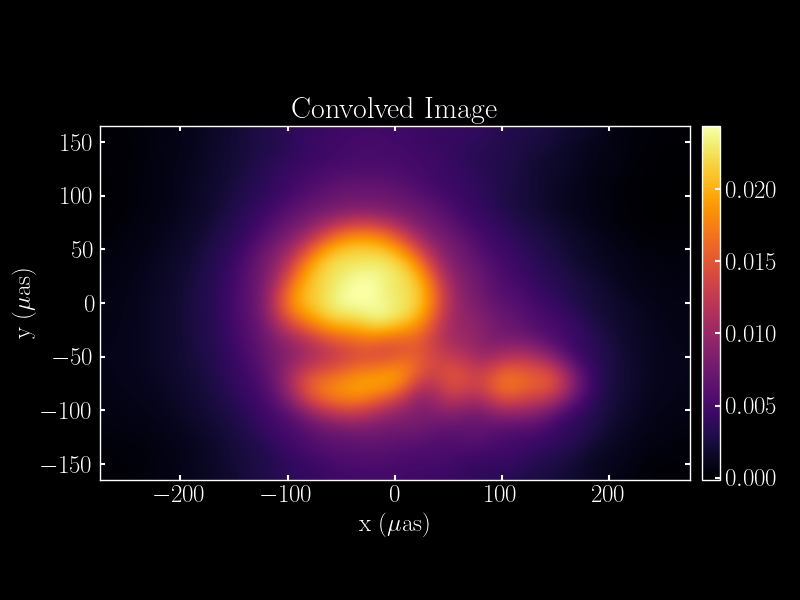

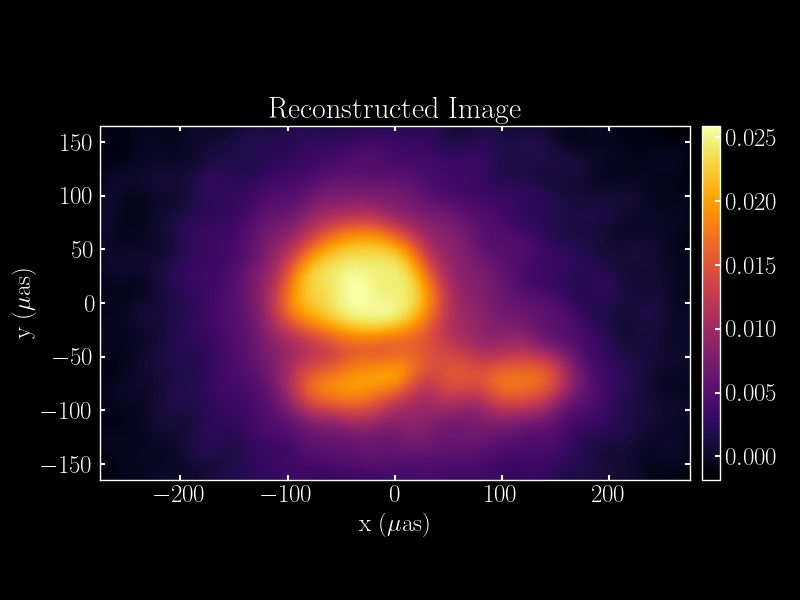

Saved: Figures/uv_plane_sampling_20250922_170139.png
Saved: Figures/psf_20250922_170139.png
Saved: Figures/original_image_20250922_170140.png
Saved: Figures/convolved_image_20250922_170140.png
Saved: Figures/reconstructed_image_20250922_170140.png


In [12]:
from datetime import datetime

%matplotlib widget
plt.close('all')
plot_factor = 1e3

# plot uv-plane sampling
fig = plt.figure(figsize=(6,6))
plt.plot(uv[:, 0], uv[:, 1], 'r.', markersize=0.1)
plt.xlim(-np.max(uv) * 1.2, np.max(uv) * 1.2)
plt.ylim(-np.max(uv) * 1.2, np.max(uv) * 1.2)
plt.title("uv-plane sampling")
plt.xlabel('u')
plt.ylabel('v')
plt.show()


# plot the PSF
psf = simulated_psf / np.sum(simulated_psf)
im_ratio = scale[1] / scale[0]
plt.figure(figsize = (8, 8))
plt.imshow(np.abs(psf * plot_factor), cmap = 'inferno', extent=extent, aspect='equal')
plt.colorbar(fraction=0.0475*im_ratio, pad=0.02)
plt.title('PSF')
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.show()

# plot the original image
original = original_array / np.sum(original_array)
plt.figure(figsize = (8, 6))
plt.imshow(original * plot_factor, cmap='inferno', extent=extent, aspect='equal')
plt.colorbar(fraction=0.0475*im_ratio, pad=0.02)
plt.title('Original Image')
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.show()

# plot the convolved image
# convolved_test = np.where(convolved_test < 0, 0, convolved_test)  # replace negative values with 0
convolved = convolved_test / np.sum(convolved_test)
plt.figure(figsize = (8, 6))
plt.imshow(convolved * plot_factor, cmap='inferno', extent=extent, aspect='equal')
plt.colorbar(fraction=0.0475*im_ratio, pad=0.02)
plt.title('Convolved Image')
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.show()

# plot the reconstructed image
# reconstructed = np.where(recon[0] < 0, 0, recon[0])  # replace negative values with 0
reconst = reconstructed / np.sum(reconstructed)
plt.figure(figsize = (8, 6))
plt.imshow(reconst * plot_factor, cmap='inferno', extent=extent, aspect='equal')
plt.colorbar(fraction=0.0475*im_ratio, pad=0.02)
plt.title('Reconstructed Image')
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.show()

def save_figure(fig, name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"Figures/{name}_{timestamp}.png"
    fig.savefig(filename, dpi=200, pad_inches=0.1)
    print(f"Saved: {filename}")

# Save all figures
for i, (fig, name) in enumerate([
    (plt.figure(1), "uv_plane_sampling"),
    (plt.figure(2), "psf"),
    (plt.figure(3), "original_image"),
    (plt.figure(4), "convolved_image"),
    (plt.figure(5), "reconstructed_image")
]):
    save_figure(fig, name)


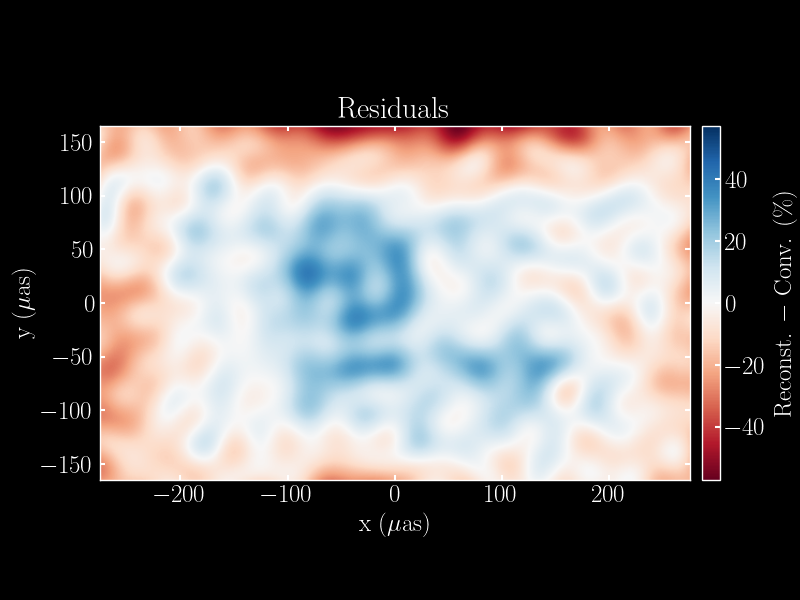

NCC: 0.9959750771522522
Mean Residual (Pixel): 11.258055686950684


In [13]:

# calculate the difference
if np.any(reconst <= 0):
    reconst_pos = reconst + np.abs(np.min(reconst))
    reconst_norm = reconst_pos / np.sum(reconst_pos)
if np.any(convolved <= 0):
    convolved_pos = convolved + np.abs(np.min(convolved))
    convolved_norm = convolved_pos / np.sum(convolved_pos)
reconst_norm = reconst / np.sum(reconst)
convolved_norm = convolved / np.sum(convolved)
difference = 100 * (reconst_norm - convolved_norm) / np.mean(convolved_norm)
# plot residuals
plt.figure(figsize = (8, 6))
plt.imshow(difference, cmap='RdBu', extent=extent, aspect='equal')

im_ratio = difference.shape[0] / difference.shape[1]

cbar = plt.colorbar(fraction=0.0475*im_ratio, pad=0.02)
cbar.set_label('Reconst. $-$ Conv. (\\%)')
clim = np.max(np.abs(difference))
plt.clim(-clim, clim)
plt.title("Residuals")
plt.xlabel('x ($\\mu$as)')
plt.ylabel('y ($\\mu$as)')
plt.show()

# compute normalised cross-correlation
from skimage.feature import match_template
ncc = match_template(convolved, reconst)

residuals = difference # in percent!
mean_res_pixel = np.sum(np.abs(residuals)) / residuals.size

print(f"NCC: {ncc[0, 0]}")
print(f"Mean Residual (Pixel): {mean_res_pixel}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
name = "residuals"
filename = f"Figures/{name}_{timestamp}.png"
plt.savefig(filename, dpi=300)

In [14]:
# from scipy.ndimage import binary_dilation

# plt.clf()
# # define a mask for the image based on the original one to check 'how much signal' is redistributed by the PSF and whether the NCC corresponds to the amount of redistribution
# mask = original > 0.05 * np.max(original)
# mask = binary_dilation(mask, iterations=30)
# inv_mask = ~mask
# # show mask
# plt.figure(figsize=(6, 6))
# plt.imshow(mask, cmap='gray', extent=(0, pix_scale[1], 0, pix_scale[0]))
# plt.title('Mask')
# plt.xlabel('x ($\\mu$as)')
# plt.ylabel('y ($\\mu$as)')
# plt.colorbar(fraction=0.0475*im_ratio, pad=0.02)
# plt.show()

# # plot recon times mask 
# plt.figure(figsize=(6, 6))
# masked_reconst = np.ma.masked_where(~mask, reconst)
# cmap = plt.cm.inferno.copy()
# cmap.set_bad('white')
# vmin = np.min(reconst)
# vmax = np.max(reconst)
# im = plt.imshow(masked_reconst, cmap=cmap, extent=(0, pix_scale[1], 0, pix_scale[0]), vmin=vmin, vmax=vmax)
# cbar = plt.colorbar(im, fraction=0.0475*im_ratio, pad=0.02)
# cbar.ax.hlines(y=0, xmin=0, xmax=1, colors='white', linewidth=4, transform=cbar.ax.get_yaxis_transform())

# plt.xlabel('x ($\\mu$as)')
# plt.ylabel('y ($\\mu$as)')
# plt.show()

# # plot recon times inv_mask
# plt.figure(figsize=(6, 6))
# masked_reconst_inv = np.ma.masked_where(~inv_mask, reconst)
# cmap_inv = plt.cm.inferno.copy()
# cmap_inv.set_bad('white')
# im_inv = plt.imshow(np.abs(masked_reconst_inv), cmap=cmap_inv, extent=(0, pix_scale[1], 0, pix_scale[0]), vmin=vmin, vmax=vmax)
# cbar_inv = plt.colorbar(im_inv, fraction=0.0475*im_ratio, pad=0.02)
# cbar_inv.ax.hlines(y=0, xmin=0, xmax=1, colors='white', linewidth=4, transform=cbar_inv.ax.get_yaxis_transform())

# plt.xlabel('x ($\\mu$as)')
# plt.ylabel('y ($\\mu$as)')
# plt.show()

# corr = np.sum(original[mask]) / np.sum(original)
# print(f"Original signal fraction within mask: {corr:.3f}, outside mask: {np.sum(original[~mask]) / np.sum(original):.3f}")

# print("NCC (original, reconstructed): {:.3f} \nFraction recon within mask: {:.3f}, outside mask: {:.3f} \nFraction convolved within mask: {:.3f}, outside mask: {:.3f}".format(ncc[0, 0], np.sum(reconst[mask]) / np.sum(reconst), np.sum(reconst[~mask]) / np.sum(reconst), np.sum(convolved[mask]) / np.sum(convolved), np.sum(convolved[~mask]) / np.sum(convolved)))
